# QSAR

## Aim of this lab

To use different machine learning alogorithms for Quantitative Structure Activity Relationship Modeling. 

### Objectives

* Use a variety of machine learning algorithms to develop QSAR models


## Background


Quantitative Structure-Activity Relationahsip (QSAR) modeling is one of the most common and useful methodologies in cheminformatics.  QSAR seeks to use machine learning algorithms to map chemical information to a biological activity.  The models can then be used for predictive purposes.

In [2]:
from rdkit.Chem import PandasTools
import pandas as pd

In [3]:
df = PandasTools.LoadSDF('data/DIAZEPAM_w_name.sdf')
df.head(3)

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

    Name                                     MolSmiles Bio_Activity ID  \
0  Mol_0  CC(C)(C)OC(=O)c1c2n(cn1)-c3ccccc3C(=O)N(C2)C        -1.28      
1  Mol_1         CN1Cc2c(ncn2-c3ccc(cc3C1=O)Cl)C(=O)OC        -0.62      
2  Mol_2   CCCOC(=O)c1c2n(cn1)-c3ccc(cc3C(=O)N(C2)C)Cl        -0.13      

                                               ROMol  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  

In [4]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

def calc_descriptors_from_mol(mol):
    """
    Encode a molecule from a RDKit Mol into a set of descriptors.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    Returns
    -------
    list
        The set of chemical descriptors as a list.

    """
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([desc[0] for desc in Descriptors.descList])
    return list(calc.CalcDescriptors(mol))

In [5]:
desc_list = []


for mol in df.ROMol.tolist():
    desc = calc_descriptors_from_mol(mol)
    desc_list.append(desc)

    
desc_frame = pd.DataFrame(desc_list)

#### Standardizing Descriptors

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

desc_frame_std = pd.DataFrame(scaler.fit_transform(desc_frame))

desc_frame_std.head()

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

        0         1         2         3         4         5         6    \
0 -0.229804 -0.700378 -0.229804 -0.490113  0.400245 -0.844430 -0.945733   
1 -0.289638 -0.294427 -0.289638  0.485646  0.362171 -1.039932 -0.961257   
2 -0.196264 -0.003103 -0.196264  0.402070  0.944074 -0.321673 -0.318295   
3 -0.191039 -0.115072 -0.191039  0.457694  0.759743 -0.321673 -0.318295   
4 -0.149571  0.202131 -0.149571  0.290525  0.861595 -0.014158  0.003185   

        7         8    9    ...  198  199  200  201  202  203  204      205  \
0 -0.839924 -0.427852  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.27735   
1 -1.048096 -1.365407  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.27735   
2 -0.326432 -0.427852  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.27735   
3 -0.326432 -0.427852  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.27735   
4 -0.017492 -0.115334  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.27735   

   206  207  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0

#### QSAR Modeling

Machine learning (ML)
ML text is adapted from the `sckit-learn` documentation [here](https://scikit-learn.org/stable/).  More information about the algorithms can be found on thier respective documentation pages. 

Classification: Identify which category an object belongs to (e.g. Active/Inactive bioassay respones, Toxic/non-toxic in humans)  
Regression: Prediction of a continuous-values attribute associated with an object (e.g., $\mu$m, AC$_50$ respones in bioassays)

A learning algorithm creates rules by finding patterns in the training data.

* Random Forest (RF): Ensemble of decision trees. A single decision tree splits the features of the input vector in a way that maximizes an objective function. In the random forest algorithm, the trees that are grown are de-correlated because the choice of features for the splits are chosen randomly.
* Support Vector Machines (SVMs): SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. The classifier is based on the idea of maximizing the margin as the objective function.
* Artificial neural networks (ANNs): An ANN is based on a collection of connected units or nodes called artificial neurons which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it.
* k-Nearest Neighbors (kNNs): A kNN predicts from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors found in the training set.

Most algorithms can be used as bother classiers and regressors, however, there are certain algorithms that are not.  The four mentioned above that we will use in this lab are applicable for both.  Scikit-learn has seperate modules for classification and regression.  Therefore, if we want to use SVM for classification, we have to import it a seperate object from SVM for regression. 

To simulate "real-world" scenarios and to ensures your models are not overfit it is best practice to seperate the compounds being used for QSAR into __training__, __validation__, and __test__ sets.  Training and validation sets are used for tuning the model parameters and finding patterns.  The test set is then used to evaluate the model's accuracy at predicting "new" or "unseen" data. 

#### Data Preperation

First we split the data into training and set sets (a portain of the training set will be used as a validation set later).  Typically the QSAR table will consists of an `X` matrix consisting of predictor variables, which in our cases are molecular descriptors and is of the shape (N, M), where N is the number of compounds and M is the number of descriptors.  The second matix `y`,  consits of the values to be predicted, e.g., the classifications of bioassay calls or AC$_{50}$ values, in the case of classification and regression, respectively.  

First we prepare these two matrices.  

In [9]:
X = desc_frame_std.copy()
y = df['Bio_Activity'].astype(float)

print(X.shape)
print(y.shape)

(42, 208)
(42,)


It is usually good practice to visualize the data in which you are trying to learn. 

In [10]:
%matplotlib inline

<AxesSubplot:>

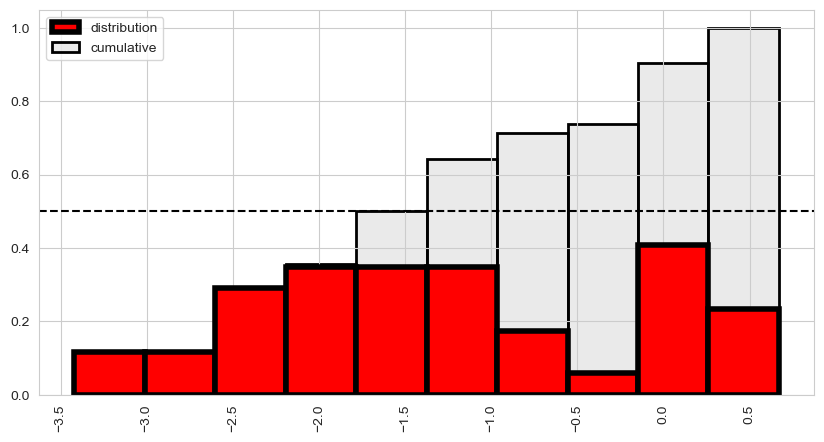

In [11]:
ax = y.hist(bins=10, edgecolor='k', lw=4, facecolor=(1, 0, 0, 1), figsize=(10,5), xrot=90, density=True, label='distribution')
y.hist(cumulative=True, density=1, bins=10, label='cumulative', zorder=0, facecolor=(0.8, 0.8, 0.8, 0.4), edgecolor='k', lw=2, figsize=(10,5))
ax.axhline(0.5, ls='--', c='k')
ax.legend()
ax

The data is somehwat uniformly distribution  from around -3.5 log to around 0.5.  At around -1.5 marks about half of the dataset.  So we can called compounds < -1.5 active and those greater inacitve.  

Typically we encode these are 0 and 1.

#### Classification

In [12]:
y_binary = y.copy()
y_binary[y < -1.5] = 1
y_binary[y >= -1.5] = 0

print("There are {:.2f}% active molecules in the dataset now.".format(y_binary.sum() / y.shape[0] * 100))

There are 45.24% active molecules in the dataset now.


The `train_test_split` function from `scikitlearn` splits our data to a provide test set size.  Here, we'll leave out 20% of our compounds as a test set.  

In [13]:
from sklearn.model_selection import KFold, train_test_split
SEED = 2008

#X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0, random_state=SEED)
X_train, y_train = X.copy(), y_binary.copy()

Get the algorithms from `scikit-learn`.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# RF
model_RF = RandomForestClassifier(n_estimators=100)

#knn
model_KNN = KNeighborsClassifier(n_neighbors=3, metric='jaccard')

models = {
    "rf": model_RF,
    "knn": model_KNN
}


In [15]:
import time
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn import clone
import numpy as np

N_FOLDS = 3

for name, ml_model in models.items():
    print("Training on", name)
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(X_train):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        test_x = X_train.iloc[test_index]
        test_y = y_train.iloc[test_index]
        
        predicted_y = fold_model.predict(test_x)
        prob_y = fold_model.predict_proba(test_x)[:, 1]
        
        accuracy = accuracy_score(test_y, predicted_y)
        sens = recall_score(test_y, predicted_y)
        spec = recall_score(test_y, predicted_y, pos_label=0)
        auc = roc_auc_score(test_y, prob_y)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )


Training on rf
Mean accuracy: 0.64 	and std : 0.06 
Mean sensitivity: 0.64 	and std : 0.22 
Mean specificity: 0.74 	and std : 0.19 
Mean AUC: 0.77 	and std : 0.04 
Time taken : 0.28s

Training on knn
Mean accuracy: 0.55 	and std : 0.13 
Mean sensitivity: 0.00 	and std : 0.00 
Mean specificity: 1.00 	and std : 0.00 
Mean AUC: 0.50 	and std : 0.00 
Time taken : 0.03s



/Users/russod/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/russod/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/russod/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/russod/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/russod/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataCo

#### Regression

For regression, we can use the same approach, but we need to change our `y` training vector to be the true continious values. 

Most of the algorithms in `sckit-learn` have both a `Classifer` and a `Regressor` interface.  Here we'll import the `Regressors`.

In [14]:
X_train, y_train = X.copy(), y.copy()

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# ANN
model_ANN = MLPRegressor(hidden_layer_sizes=(5, 3), random_state=SEED)

# SVM
model_SVM = SVR(kernel="rbf", C=1, gamma=0.1)

# RF
model_RF = RandomForestRegressor(n_estimators=100)

#knn
model_KNN = KNeighborsRegressor(n_neighbors=3, metric='jaccard')


models = {
    "rf": model_RF,
    "svm": model_SVM,
    "ann": model_ANN,
    "knn": model_KNN
}


The metrics used to evaluate classication models are not the same as those used for evaluating regression models.  Typically, there are two metrics __r$^2$__ and the __mean absolute error (MAE)__.

In [16]:
import time
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import clone
import numpy as np

N_FOLDS = 3

for name, ml_model in models.items():
    print("Training on", name)
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    r2_per_fold = []
    mae_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(X_train):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        test_x = X_train.iloc[test_index]
        test_y = y_train.iloc[test_index]
        
        predicted_y = fold_model.predict(test_x)

        
        r2 = r2_score(test_y, predicted_y)
        mae = mean_absolute_error(test_y, predicted_y)

        r2_per_fold.append(r2)
        mae_per_fold.append(mae)

    # Print statistics of results
    print(
        f"Mean r2: {np.mean(r2_per_fold):.2f} \t"
        f"and std : {np.std(r2_per_fold):.2f} \n"
        f"Mean mae: {np.mean(mae_per_fold):.2f} \t"
        f"and std : {np.std(mae_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )


Training on rf
Mean r2: 0.42 	and std : 0.04 
Mean mae: 0.63 	and std : 0.06 
Time taken : 0.64s

Training on svm
Mean r2: -0.36 	and std : 0.26 
Mean mae: 1.04 	and std : 0.10 
Time taken : 0.03s

Training on ann


/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Mean r2: 0.14 	and std : 0.24 
Mean mae: 0.82 	and std : 0.09 
Time taken : 0.51s

Training on knn
Mean r2: -0.76 	and std : 0.83 
Mean mae: 1.16 	and std : 0.31 
Time taken : 0.08s



/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
